# Teaching task: Behavioral plots
Natalia Vélez, October 2021

This code was used to create (1) PDF files of each participant's trial-by-trial examples and ratings, and (2) plots showing the frequency of examples and average ratings across all participants. You can view the results of this script on [OSF](https://osf.io/sp5tc/files/osfstorage/63067b1980b0d8244bfe907d).

In [1]:
%matplotlib inline

import os, json, re, sys
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib import colors
from matplotlib.backends import backend_pdf
import seaborn as sns

sys.path.append('..')
from utils import int_extract, read_json
from teaching_models import problems, excluded

sns.set_context('talk')
sns.set_style('white')

# Make directory to store plots in 
os.makedirs('plots/examples_agg', exist_ok=True) # avg heatmaps
os.makedirs('plots/examples_ind', exist_ok=True) # ind subjects

Loading teaching problems
{'A': [[0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0]],
 'B': [[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'C': [[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'D': [[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]}
Participants excluded from analysis:
[3, 17]
Cleaning up human behavioral data
    subject  run  block_idx  ex_idx first_movement   start  problem  \
0         1    1          0       0         [0, 1]  [0, 0]       22   
1         1    1          0       1         [0, 1]  [0, 0]       22   
3         1    1          1   

In [2]:
with open('inputs/problems.json', 'r') as f:
    problems = json.load(f)

Load behavioral data:

In [3]:
teaching_df = pd.read_csv('outputs/teaching_behavior.csv')
teaching_df = teaching_df[~teaching_df.subject.isin(excluded)]
teaching_df[['block_idx', 'ex_idx', 'problem']] = teaching_df[['block_idx', 'ex_idx', 'problem']].astype(int)
teaching_df['rating'] = teaching_df['rating'] + 1
teaching_df['start'] = teaching_df['start'].apply(literal_eval)

print(teaching_df.shape)
teaching_df.tail()

(3360, 11)


,subject,run,block_idx,ex_idx,first_movement,start,onset,problem,order,example,rating
3583,30,10,2,1,"[5, 4]","[5, 5]",194.60,28,"['D', 'A', 'C', 'B']","[3, 2]",3.0
3584,30,10,2,2,"[5, 4]","[5, 5]",209.35,28,"['D', 'A', 'C', 'B']","[1, 3]",5.0
3585,30,10,3,0,"[0, 1]","[0, 0]",254.95,13,"['D', 'B', 'A', 'C']","[2, 2]",1.0
3586,30,10,3,1,"[0, 1]","[0, 0]",268.95,13,"['D', 'B', 'A', 'C']","[3, 2]",3.0
3587,30,10,3,2,"[0, 1]","[0, 0]",283.85,13,"['D', 'B', 'A', 'C']","[3, 3]",4.0


## Individual responses

In [4]:
def plot_subject_examples(sub, prob_idx):
    # Load data for selected problem
    block = teaching_df[(teaching_df['subject'] == sub) & (teaching_df['problem'] == prob_idx)]
    prob = problems[prob_idx]

    # Find order in which alternatives were presented
    order = block.iloc[0]['order']
    order = re.findall('[A-Z]', order)
    true_h = prob['A']

    # Split up figure layout
    fig=plt.figure(constrained_layout=True, figsize=(8,7.25))
    grid = plt.GridSpec(3,4, figure=fig)
    prob_axes = [plt.subplot(grid[:1,c]) for c in range(4)]
    ex_ax = plt.subplot(grid[1:,:2])
    rating_ax = plt.subplot(grid[1:,2:])

    fig.suptitle('sub-%02d: Problem #%i' % (sub, prob_idx))

    ## TEACHING PROBLEM
    labels = ['A', 'B', 'C', 'D']
    pad = 0.2

    # Plot each hypothesis
    for idx, opt in enumerate(order):
        sns.heatmap(prob[opt], ax=prob_axes[idx], square=True, cbar=False, xticklabels=False, 
                    yticklabels = [' ', ' ', ' ', ' ', ' '], 
                    cmap='Greys', linecolor='#aaa', linewidths=1)

        if opt == 'A':
            prob_axes[idx].set(title = '*%s*' % labels[idx])
        else:
            prob_axes[idx].set(title = labels[idx])


    ## EXAMPLES SELECTED
    true_cm = colors.LinearSegmentedColormap.from_list('true_extent', ['#fff', '#ccc'])
    ex_cm = ['#11286B', '#2E6A88', '#4BACA4']

    sns.heatmap(true_h, square=True, cbar=False, xticklabels=False, yticklabels=False, cmap=true_cm, linecolor='#aaa', linewidths=1, ax=ex_ax)
    
    valid_examples = block.dropna(subset=['example'])
    for _, row in valid_examples.iterrows():
        ex = re.findall('[0-9]', row['example'])
        ex = [int(coord) for coord in ex]
        ex = ex[::-1] # fix coordinate system

        ex_rect = Rectangle(ex, 1, 1, facecolor=ex_cm[row['ex_idx']], edgecolor='#aaa', linewidth=1)
        ex_ax.add_patch(ex_rect)

        text = ex_ax.text(ex[0]+.5, ex[1]+.5, row['ex_idx']+1, ha='center', va='center', color='w', fontweight='bold')
    ex_ax.set(title='Examples')
    
    # Plot starting point
    start_coords = block['start'].iloc[0]
    start_coords = start_coords[::-1]
    
    start_rect = Rectangle(start_coords, 1, 1, fill=None, edgecolor='red', linewidth=1)
    ex_ax.add_patch(start_rect)

    ## RATINGS
    rating_ax.plot(block.ex_idx+1, block.rating, marker='o')
    rating_ax.set(xlabel='Example', ylabel = None, xlim=(0.5,3.5), ylim=(0.5,5.5), 
                  xticks = np.arange(1,4), yticks = np.arange(1,6),
                  aspect=.5, title='Ratings')

    return fig

KeyboardInterrupt: 

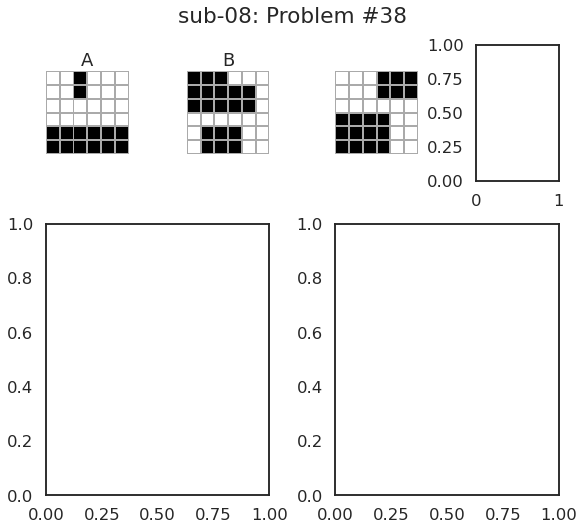

In [5]:
for sub, sub_data in teaching_df.groupby('subject'):
    pdf = backend_pdf.PdfPages("plots/examples_ind/sub-%02d.pdf" % sub)
    for prob, prob_data in sub_data.groupby('problem'):
        fig = plot_subject_examples(sub, prob)
        pdf.savefig(fig)
        plt.close(fig)
    pdf.close()

## Aggregate plots

Helper function: Count how often each pixel is selected as an example

In [6]:
def example_frequencies(prob_idx):
    # Find true hypothesis
    prob = problems[prob_idx]

    # Tally number of examples
    examples = teaching_df[teaching_df['problem'] == prob_idx].copy()
    examples = examples[examples['example'].notna()]
    example_count = np.zeros((6,6))

    for _, row in examples.iterrows():
        ex = re.findall('[0-9]', row['example'])
        ex = [int(coord) for coord in ex]

        example_count[ex[0], ex[1]] += 1

    # Convert counts -> frequencies
    example_freq = example_count/np.sum(example_count) 
    return example_freq

Helper function: Plot examples and trial-by-trial ratings for a given teaching problem

In [7]:
def plot_problem(prob_idx):
    # Load examples
    prob = problems[prob_idx]
    true_h = np.array(prob['A'])
    freqs = example_frequencies(prob_idx) # examples

    # Split up figure layout
    fig=plt.figure(constrained_layout=True, figsize=(8,7.25))
    grid = plt.GridSpec(3,4, figure=fig)
    prob_axes = [plt.subplot(grid[:1,c]) for c in range(4)]
    ex_ax = plt.subplot(grid[1:,:2])
    rating_ax = plt.subplot(grid[1:,2:])

    fig.suptitle('Problem %i' % prob_idx)

    ## TEACHING PROBLEM
    labels = ['A', 'B', 'C', 'D']
    pad = 0.2

    # Plot each hypothesis
    for idx, opt in enumerate(labels):
        sns.heatmap(prob[opt], ax=prob_axes[idx], square=True, cbar=False, xticklabels=False, yticklabels = [' ', ' ', ' ', ' ', ' '], cmap='Greys', linecolor='#aaa', linewidths=1)

        if opt == 'A':
            prob_axes[idx].set(title = '*%s*' % labels[idx])
        else:
            prob_axes[idx].set(title = labels[idx])

    # Plot examples
    sns.heatmap(freqs, ax=ex_ax, cbar=False, square=True, annot=True, cmap='viridis', mask=true_h==0, linewidth=1,
                annot_kws={"fontsize":10})
    ex_ax.set(title='Examples', xticklabels=[], yticklabels=[])

    # Plot ratings
    ratings = teaching_df[teaching_df['problem'] == prob_idx].copy() # ratings
    sns.pointplot(data=ratings, x='ex_idx', y='rating', ax=rating_ax)
    rating_ax.set(title='Ratings', xlabel='Trial', ylabel='', xlim=(-0.5, 2.5), ylim=(0.5,5.5),
                 yticks=(1,2,3,4,5))
    
    return fig

Helper: Plot just the ratings and examples (for paper figures):

In [8]:
def plot_agg_results(prob_idx):

    # Load examples
    prob = problems[prob_idx]
    true_h = np.array(prob['A'])
    freqs = example_frequencies(prob_idx) # examples

    # Split up figure layout
    fig=plt.figure(constrained_layout=True, figsize=(6,4))
    grid = plt.GridSpec(1,5, figure=fig)
    ex_ax = plt.subplot(grid[:3])
    rating_ax = plt.subplot(grid[3:])

    fig.suptitle('Problem %i' % prob_idx)

    ## TEACHING PROBLEM
    labels = ['A', 'B', 'C', 'D']
    pad = 0.2

    # Plot examples
    sns.heatmap(freqs, ax=ex_ax, cbar=True, square=True, annot=False, cmap='viridis', mask=true_h==0, linewidth=1)
    ex_ax.set(title='Examples', xticklabels=[], yticklabels=[])

    # Plot ratings
    ratings = teaching_df[teaching_df['problem'] == prob_idx].copy() # ratings
    ratings['ex_idx'] = ratings['ex_idx'] + 1
    sns.pointplot(data=ratings, x='ex_idx', y='rating', ax=rating_ax)
    rating_ax.set(title='Ratings', xlabel='# Examples', ylabel='', ylim=(0.5,5.5),
                 yticks=(1,2,3,4,5))

    return fig

In [9]:
for idx in range(len(problems)):
    fig = plot_problem(idx)
    plt.savefig('plots/examples_agg/problem_%02d.png' % idx)
    plt.close(fig)
    
    fig2 = plot_agg_results(idx)
    plt.savefig('plots/examples_agg/problem_%02d_results.png' % idx)
    plt.close(fig2)